In [1]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import matplotlib.pyplot as plt
from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
%load_ext cython
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

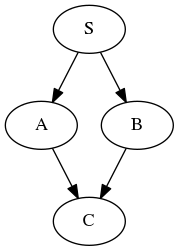

In [3]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb')

In [4]:
data = simulate(par, stim_N=10000, J_AC=2.0, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)

simulating  425422.0
stimulating  10000
connecting  J_AC 2.0


In [5]:
t_stop = data['status']['time']
spiketrains = [s['times'] for s in data['spiketrains']]
names = ['A', 'B', 'C']

In [6]:
A_spikes, B_spikes, C_spikes = spiketrains

In [7]:
stim_times = data['epoch']['times']

## Visualize some spikes

Text(0.5,0,'time (ms)')

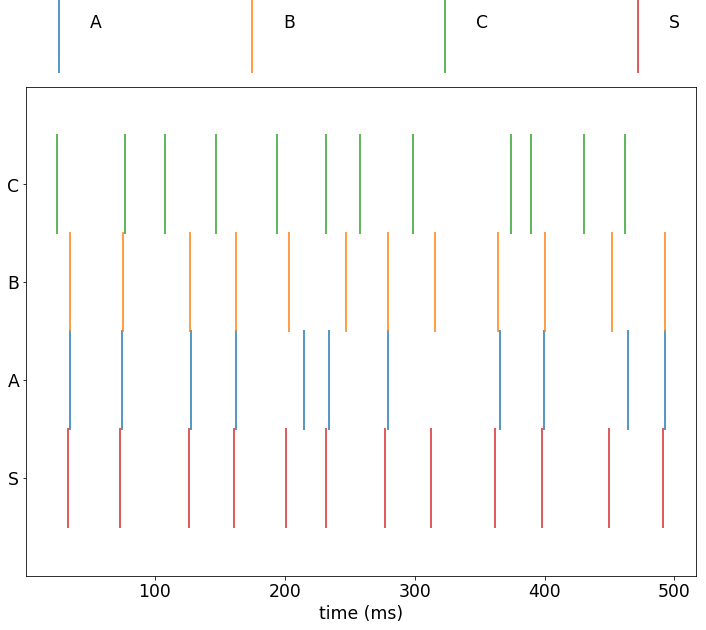

In [8]:
s = 10000
t0, t1 = 0, 500
A_mask = (A_spikes > t0) & (A_spikes < t1)
B_mask = (B_spikes > t0) & (B_spikes < t1)
C_mask = (C_spikes > t0) & (C_spikes < t1)
S_mask = (stim_times > t0) & (stim_times < t1)
plt.scatter(A_spikes[A_mask], 1.01*np.ones(sum(A_mask)), marker='|', s=s, label='A')
plt.scatter(B_spikes[B_mask], 1.02*np.ones(sum(B_mask)), marker='|', s=s, label='B')
plt.scatter(C_spikes[C_mask], 1.03*np.ones(sum(C_mask)), marker='|', s=s, label='C')
plt.scatter(stim_times[S_mask], 1.*np.ones(sum(S_mask)), marker='|', s=s, label='S')
plt.yticks([1.01, 1.02, 1.03, 1],['A', 'B', 'C', 'S']);
plt.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=3,
           ncol=4, mode="expand", frameon=False)
plt.ylim(0.99, 1.04)
plt.xlabel('time (ms)')

In [17]:
%%cython
import numpy as np
from libc.math cimport exp, sqrt

cdef double _sqrt_2_pi = sqrt(2 * np.pi)


cdef double _norm_pdf(double x):
    return exp(- x * x / 2.0) / _sqrt_2_pi


def cpdf(double[:] x, double[:] y, double delta_t, double sigma):
    '''
    Conditional probability density function (PDF) 
    for x evaluated at y + delta_t scaled by sigma that is
    p(Y=y|X=x) = sum_y(exp(-(z/sigma)^2) / (sqrt(2pi)*sigma)), 
    z = x - y - delta_t.
    '''
    cdef int i, j, M, N
    cdef double z, tmp
    cdef double[:] pdf
    M, N = len(x), len(y)
    pdf = np.zeros(M)
    for i in range(M):
        for j in range(N):
            z = x[i] - y[j] - delta_t
            tmp = _norm_pdf(z / sigma) / sigma
            pdf[i] = pdf[i] + tmp / N
    return np.array(pdf)

In [18]:
def xcorr(t1, t2, binsize=1e-3, limit=[-1, 1], density=False):
    '''
    Cross correlation histogram (CCH) of t1 vs t2
    '''
    if isinstance(limit, (int, float)):
        limit = [-limit, limit]
    bins = np.arange(limit[0], limit[1] + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 + limit[0])
    jj2 = np.searchsorted(t2, t1 + limit[1])
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins, density=density)
    
    return bins[1:], count

In [19]:
def fit_latency(pre, post, binsize=.1, limit=[-20, 0], init=[0.5, 0.5], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.norm.pdf(x, p[0], p[1])
    error  = lambda p, x, y: (y - normpdf(p, x))
    (delta_t, sigma), _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf((delta_t, sigma), b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.2f} $\sigma$ {:.2f}'.format(delta_t, sigma))
        plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return delta_t, sigma

In [20]:
def vlines(X, label=None, **kwargs):
    '''
    Multiple vertical lines spanning the axes
    '''
    for i, x in enumerate(X):
        if label and i == len(X)-1:
            kwargs.update({'label': label})
        a = plt.axvline(x, **kwargs)
    return a

# Stage 1
## Find the latency of stimulation and spikes
Note: we are finding the negative latency such that we can find the PDF of stim_times given spikes + (- delta_t)

## stimulation vs A

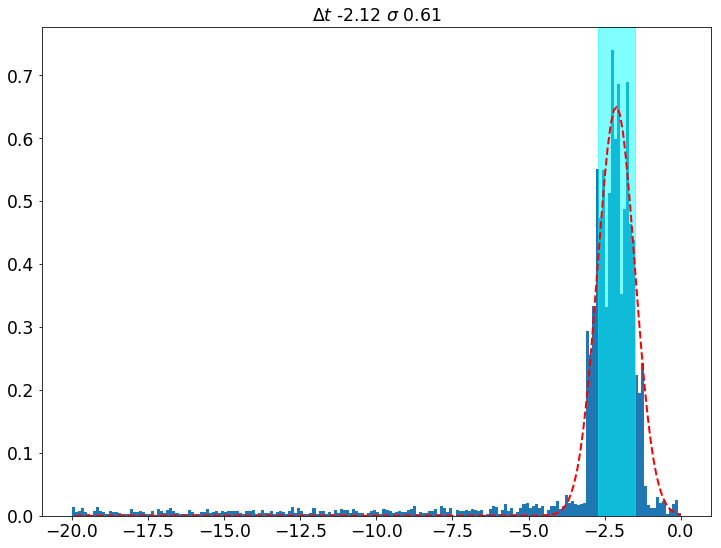

In [22]:
delta_t, sigma = fit_latency(A_spikes, stim_times, plot=True)

In [23]:
pdf_A = cpdf(stim_times, A_spikes, delta_t, sigma) 

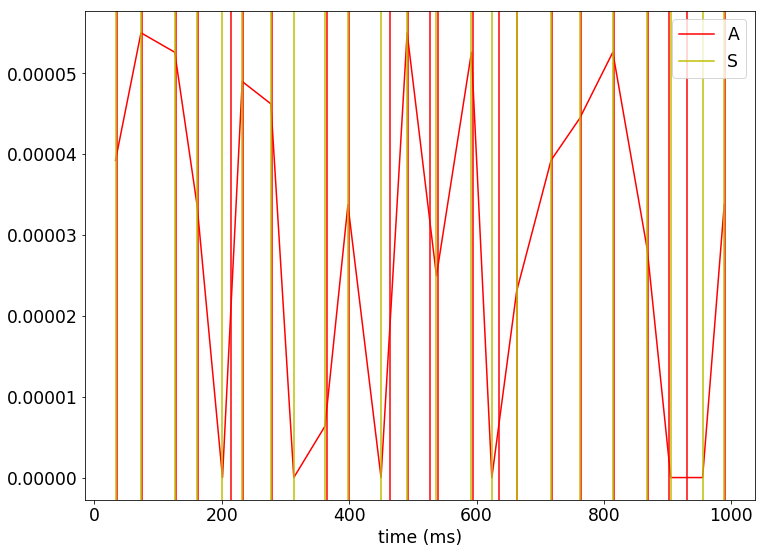

In [24]:
t0, t1 = 0, 1000

A_mask = (A_spikes > t0) & (A_spikes < t1)
S_mask = (stim_times > t0) & (stim_times < t1)

plt.plot(stim_times[S_mask], pdf_A[S_mask], 'r')

a = vlines(A_spikes[A_mask], c='r', label='A')
b = vlines(stim_times[S_mask], c='y', label='S')
plt.xlabel('time (ms)')
plt.legend(handles=[a,b]);

As we can see from the above plot, the PDF of stimulation times given spikes from A yield ~0 at unsuccsessfull stimulations and > 0 at successfull stimulations. This is stronger than only utilizing the stimulation time points where a spike from A preceeded as we get much more datapoints. 

## stimulation vs B

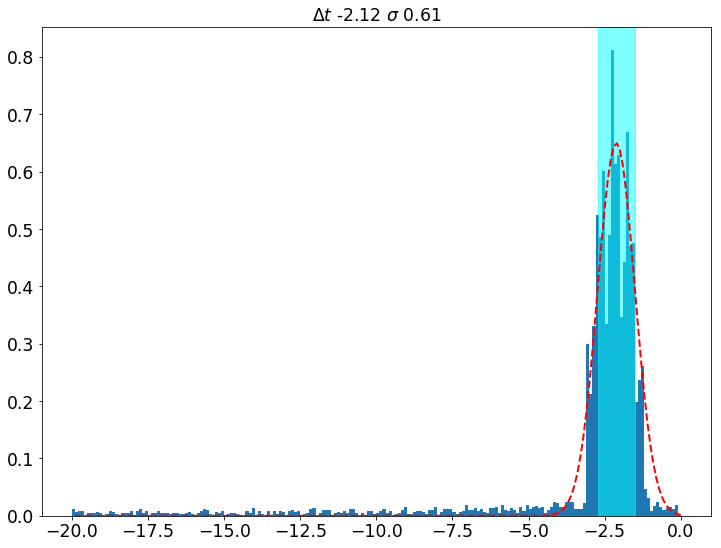

In [25]:
delta_t, sigma = fit_latency(B_spikes, stim_times, plot=True)

In [26]:
pdf_B = cpdf(stim_times, B_spikes, delta_t, sigma) 

Text(0.5,0,'time (ms)')

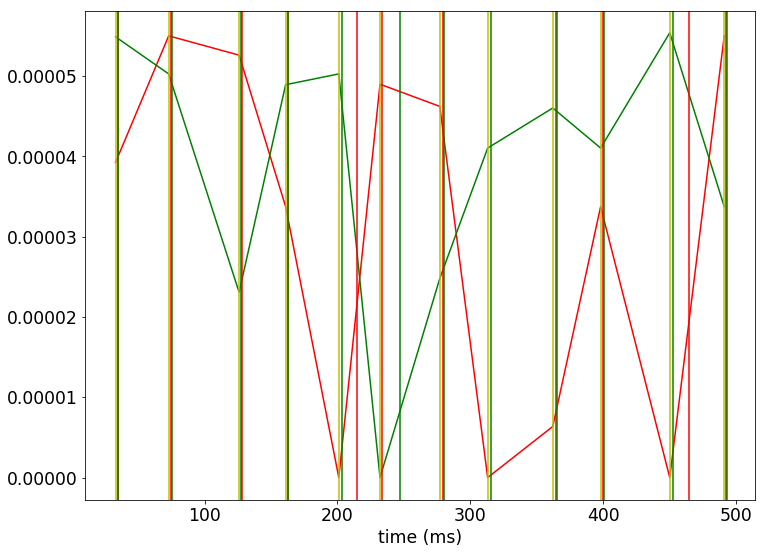

In [27]:
t0, t1 = 0, 500

A_mask = (A_spikes > t0) & (A_spikes < t1)
B_mask = (B_spikes > t0) & (B_spikes < t1)
S_mask = (stim_times > t0) & (stim_times < t1)

plt.plot(stim_times[S_mask], pdf_A[S_mask], 'r')
plt.plot(stim_times[S_mask], pdf_B[S_mask], 'g')

vlines(A_spikes[A_mask], c='r')
vlines(B_spikes[B_mask], c='g')
vlines(stim_times[S_mask], c='y')
plt.xlabel('time (ms)')

## stimulation vs C

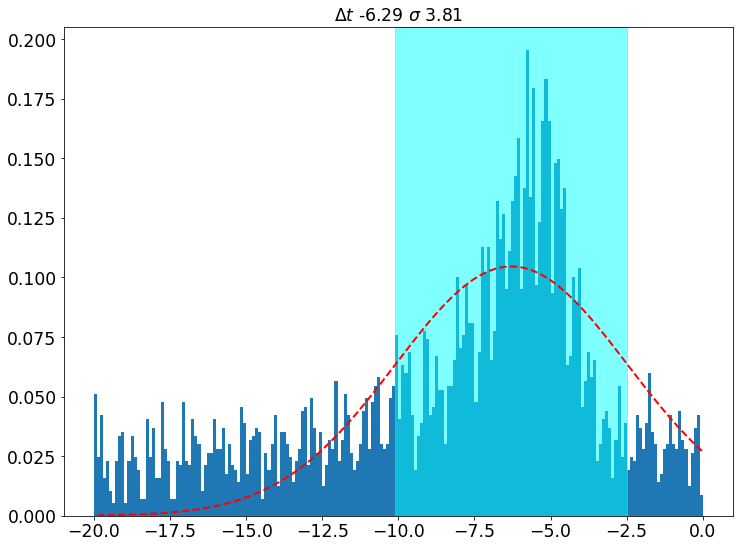

In [28]:
delta_t, sigma = fit_latency(C_spikes, stim_times, plot=True)

In [29]:
pdf_C = cpdf(stim_times, C_spikes, delta_t, sigma) 

Text(0.5,0,'time (ms)')

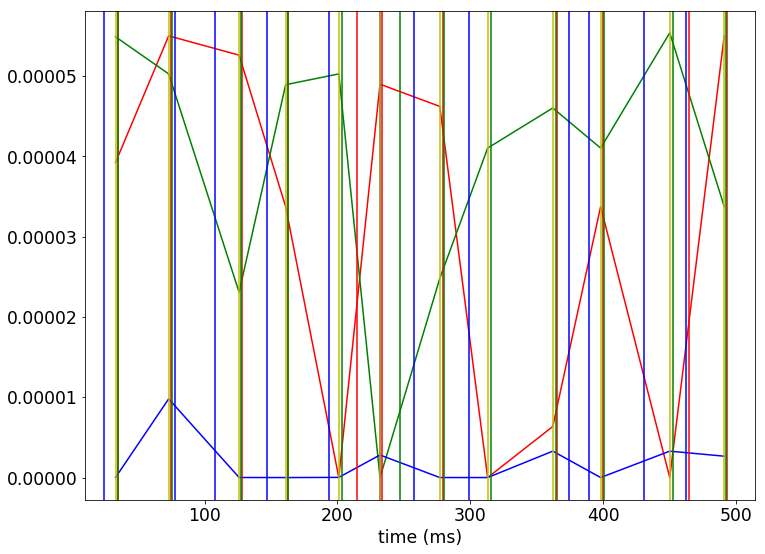

In [49]:
t0, t1 = 0, 500

A_mask = (A_spikes > t0) & (A_spikes < t1)
B_mask = (B_spikes > t0) & (B_spikes < t1)
C_mask = (C_spikes > t0) & (C_spikes < t1)
S_mask = (stim_times > t0) & (stim_times < t1)

plt.plot(stim_times[S_mask], pdf_A[S_mask], 'r')
plt.plot(stim_times[S_mask], pdf_B[S_mask], 'g')
plt.plot(stim_times[S_mask], pdf_C[S_mask], 'b')

vlines(A_spikes[A_mask], c='r')
vlines(B_spikes[B_mask], c='g')
vlines(C_spikes[C_mask], c='b')
vlines(stim_times[S_mask], c='y')
plt.xlabel('time (ms)')

(0, 5000)

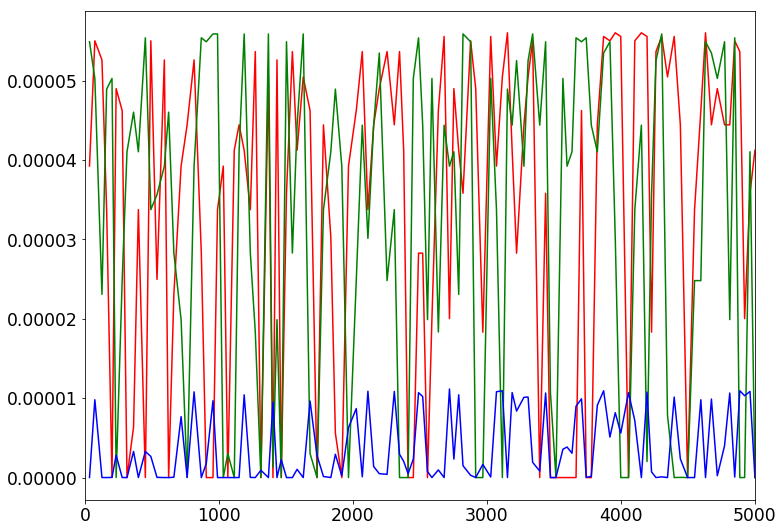

In [31]:
plt.plot(stim_times, pdf_A, 'r')
plt.plot(stim_times, pdf_B, 'g')
plt.plot(stim_times, pdf_C, 'b')
plt.xlim(0,5000)

# Stage 2
The final stage consists of a simple ordinary linear regression

In [32]:
beta_AC = np.cov(pdf_C, pdf_A)[0,1] / np.var(pdf_C)
beta_BC = np.cov(pdf_C, pdf_B)[0,1] / np.var(pdf_C)
print(beta_AC, beta_BC)

0.8153248657786082 0.04260432005337134


In [47]:
def pdf_wald(pdf_pre, pdf_post):
    z_s1_x0 = pdf_pre < 1e-8
    z_s1_x1 = z_s1_x0 == False
    
    y_s1_x0 = pdf_post[z_s1_x0]
    y_s1_x1 = pdf_post[z_s1_x1]
    
    y_s1 = (y_s1_x1.sum() - y_s1_x0.sum()) / (z_s1_x1.sum() - z_s1_x0.sum())
    
    return y_s1

In [48]:
beta_AC_w = pdf_wald(pdf_A, pdf_C)
beta_BC_w = pdf_wald(pdf_B, pdf_C)
print(beta_AC_w, beta_BC_w)

5.524285402655453e-06 4.233945880892278e-06


In [55]:
pdf_A / pdf_C

array([6.57549406e+003, 5.61289225e+000, 7.40080170e+003, ...,
       5.16282316e+000, 6.00354558e+032, 1.87430922e-227])

# Corrections
To correct for baseline activity we calculate the PDFs 15 ms before the actual stimulation

In [34]:
time_shift = 10

In [35]:
delta_t, sigma = fit_latency(A_spikes, stim_times)
pdf_Ar = cpdf(stim_times - time_shift, A_spikes, delta_t, sigma) 

In [36]:
delta_t, sigma = fit_latency(B_spikes, stim_times)
pdf_Br = cpdf(stim_times - time_shift, B_spikes, delta_t, sigma) 

In [37]:
delta_t, sigma = fit_latency(C_spikes, stim_times)
pdf_Cr = cpdf(stim_times - time_shift, C_spikes, delta_t, sigma) 

In [38]:
beta_ACr = np.cov(pdf_Cr, pdf_Ar)[0,1] / np.var(pdf_Cr)
beta_BCr = np.cov(pdf_Cr, pdf_Br)[0,1] / np.var(pdf_Cr)
print(beta_ACr, beta_BCr)

0.27890867456436436 0.0029059752087348474


# Final result

In [39]:
beta_AC_corrected = beta_AC - beta_ACr
beta_BC_corrected = beta_BC - beta_BCr
print(beta_AC_corrected, beta_BC_corrected)

0.5364161912142438 0.039698344844636496


(6.544307060336826e-141, 1.1155025108173648e-05)

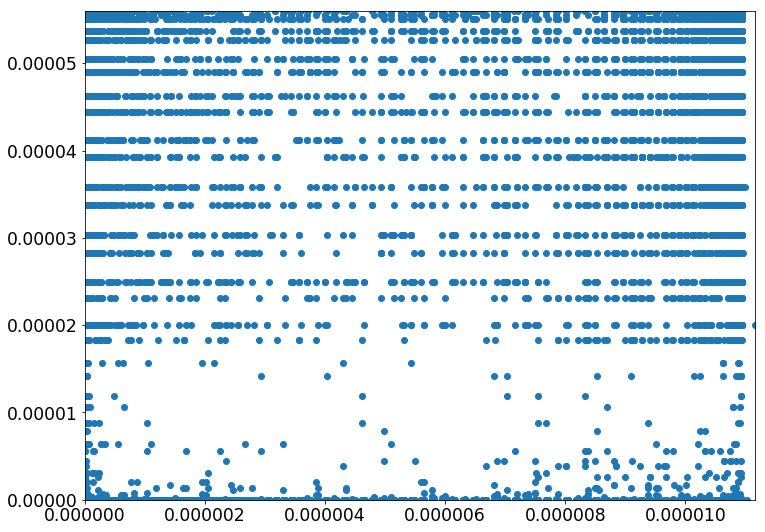

In [40]:
plt.scatter(pdf_C, pdf_A)
plt.ylim(min(pdf_A), max(pdf_A))
plt.xlim(min(pdf_C), max(pdf_C))